# KFServing samples

## 1. KFServing

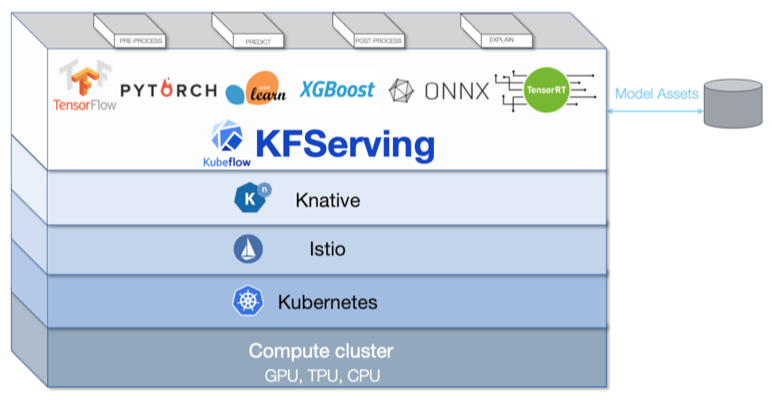


## 1. KFServing with kubectl

Our first example will use a [sklearn model](https://github.com/kubeflow/kfserving/tree/master/docs/samples/sklearn) trained with the [iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset. This dataset has 3 output classes: (Iris Setosa, Iris Versicolour, and Iris Virginica)

Then, we serve our model using the KFServing platform by running kubectl.


In [ ]:
## Initial cluster variables
## Update the kubeflow_url to your Kubeflow dashboard endpoint if it's running on a remote cluster.

import os
kubeflow_url = 'istio-ingressgateway.istio-system'
os.environ["kubeflow_url"] = kubeflow_url

Next, we need to define the Kubernetes yaml for deploying this model.

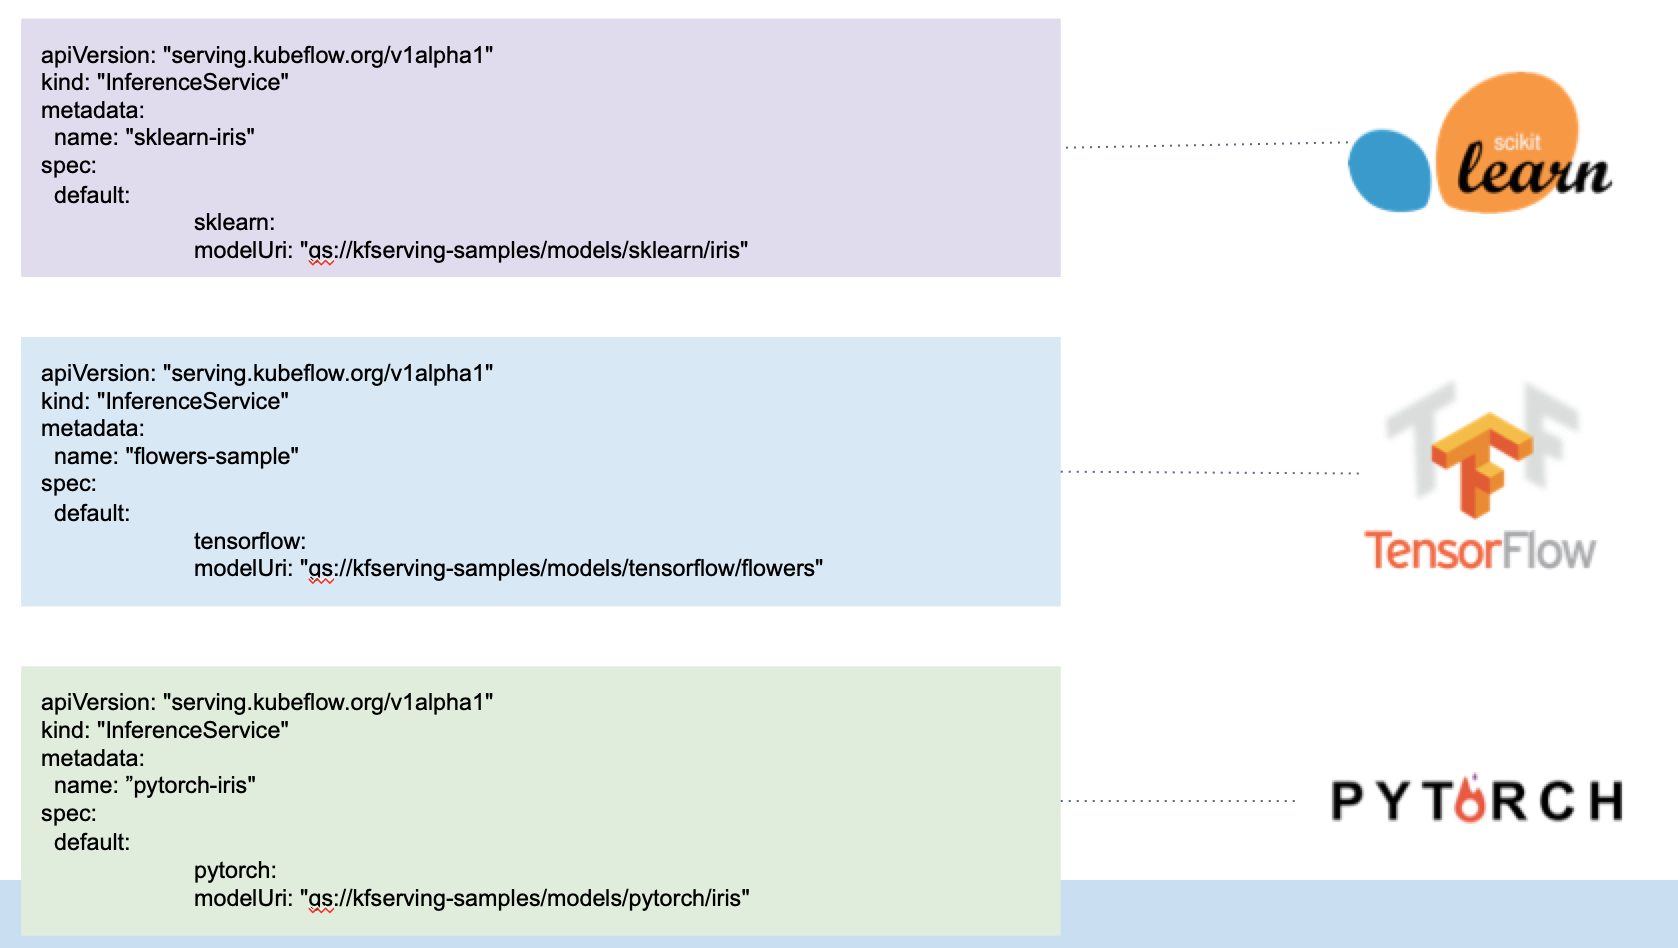

In [ ]:
import textwrap
sklearn_yaml = textwrap.dedent("""\
apiVersion: "serving.kubeflow.org/v1alpha2"
kind: "InferenceService"
metadata:
  name: "sklearn-iris"
spec:
  default:
    predictor:
      sklearn:
        storageUri: "gs://kfserving-samples/models/sklearn/iris"
""")
f = open("sklearn.yaml", "w")
f.write(sklearn_yaml)
f.close()

In [ ]:
!kubectl apply -f sklearn.yaml

In [ ]:
!kubectl get pod | grep sklearn-iris
!kubectl get inferenceservice sklearn-iris

Once the model is ready, we then can do model prediction using a simple curl command.

In [ ]:
%%bash
MODEL_NAME=sklearn-iris
SERVICE_HOSTNAME=$(kubectl get inferenceservice sklearn-iris -o jsonpath='{.status.url}' | cut -d "/" -f 3)
curl -v -H "Host: ${SERVICE_HOSTNAME}" http://$kubeflow_url/v1/models/$MODEL_NAME:predict -d '{"instances": [[6.8,  2.8,  4.8,  1.4],[6.0,  3.4,  4.5,  1.6]]}'

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all

## 2. KFServing with Python SDK

### Install the necessary kfp and kfserving library

In [ ]:
!pip install kfp-tekton --upgrade -q
!pip install kfserving --upgrade -q 
!pip install keras==2.2.5 -q
!pip install scikit-image -q

In [ ]:
## Initial variables and helper functions
import requests

model_name = 'tf-flower'
tf_request = {  
            "instances":[  
            {  
                "image_bytes":{  
                    "b64":"/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAErASsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwC9A42ir9vA0nOOKxYJhkDqe1bNvO0ZAYdaIsC8LLjOwH60yWDAwY1/75qzDcDAz0qfhl55BqxGE1pCzZwVPt0qJ7MgZQbh7da1Z7bncBVQgoaVhlGFvKlBIwOhqxPFxkdKmdY5xiQYP94daaqtGPKkO5P4X/pU2AoKMMQatWv+tAPXpTJ4ipyBTVYqwYHBFTezA1ivHNRsuRU1tOlymOBIOo9aVoyGNaCIEHanEEEMKXbg07BAx2NICXO5KrvwcVPEcDFRyD5qTYDYhuPuKnA4waitxmQj1FWGX9Ka2ArODzUXU5qxIM81AODzUtjGzHMfvVRcl6mmOMio4V3PSAtwjBUd60l+6DVCMAzH2q6D8v0qo7CIJ3xmsqQ8kmtC5YAVmyctntSbGRkDOT0qWMFyABUWNzD0q5EuxM9zQgJQAqgCkJxS9vemMasA3c8CpFPHNRBgBkinBvSpuBMGxRnPWo1561IOlMBQMEU2R8DFKW2rk1XdsmgCN+TmqskuHIqeUhVNZMkoZyckZqQILTi5UntzWtHMOVbpWQh2zCr6jIBpRGzUjl2jBPHY1chuSODyKx4pOzdKnVyh68VYjbDBlyvSq88G4bhVeG4Kkc8HrV3eGUEVQjLkUr+FRmQgYzV+aMODxzWdIpU0mMerh1wahdCpPvTN21gQamB3jB+qn1rOQDI5GjcMvBFbdvMt1FkfeHWsJhzU1pcG3nDZ4PWlGVgNd4+MigL8uKscMgdeVNRsAORVsRGFwc1G45qfKg/MM/U0jLG3RQPxNS2BCh2OG9DVxwM57GqxRQc8j9asp80I5zjiiIyu64zVdhxVtwMVVak2BUlOTUlumATTXXmpPux0r6AS2vLv7GrLNtFVbM/K596knbgGqT0AqXLZeqbgsRU8x96hJzgCk2A+JPmA61PA4mUSL9wk7fcetULtmEMdvGSJrltgI6hQMsfwH6kVqRIsUaqgAVQAAOwFUgEJ7UwDOc1Ky55/OmtgcCi4EZ6UqqSc0Hk4p46igB44pQaaM5NI7hVx3qkA2V8nHaoAdzE9hTZHOMd6ZczfZoQq/fNDArahcgAxLyf4iKzs0OxJ5696ZUDQP97NaVsdyg+1IPszHlFzU8SRg4jGB6VSQh3linp02mpQm5enNJs9aoBoynfirMFwVOD0qADjDUn3W9qANIsGGQeKqXCK3PekjlIOCeKfJyN1AGXIMZFNik6xscc5U+hqxMgbPrVFwVas2BezvXOMOPvCo2GD7UyOXOG/iHX3p8hGzdn6Vm0M0rG8ZLYxtzz8pp0lyx/iNZUMpzzVkturURKZGP8AEfzpRMw6Nmq5HvTMspz1pAaUVzzhjiptxjPmRnjuKyBNzzxU8NwUbDcqaXoBreYJU3L+VVn5zTEcRvkHKNUjcE4qZdwITyabK3yGpG4GaqzN+7qG9ALNicwn/eNE75UgU2zb/RQfc0krY4rS+gFZgcc0iKM+9Kc81FcI727QxnDyjbu9AepoWrAZpv8Apt7NqB5jA8mAeig/MfxOPyFa4HFQ20KW8KQxrhEUKB7VYXFWAvlkhSDx1PvUchwSAKlD7Uyep6CoS3UnrU9QGHg0DJ5xSb8mjdjvVAOZ9oqs75JOaJX3Hg1GBmmAKRuLt0Xms24lMshbt2qxezgDyEPuxqkxpNjImo4pGOOarmbk0gJvMINWIbp42BB6VBLC0Z9qjVsGjYDqrWVJ4w6n6j0qcxbh71ztndtbyBlPHcetdLayx3Me+Ns+o7irTuJkDRDvwaYVIODWg0IYc9agkgBGDTEUyCv0pwc4wac8ZTg9KjYFRSAil6ZxVOYZFXGPBBqpKKljIFJB61KzFlqJhTkbPBrO+oxysR0qwrkjk1Wxg1IoPBJ4PpSc7BYkOfU0zzHXvke9WNuFBHQ1A/BrKVRoaQm/dweDShyOOtRZB+tAPHNSq6HYv203/LNuh6VeVvkweq1ioxB+lacUm5Nw7jBrVTUoktEsp+SqNw2F4q1I3yCqM5yQKwchpF62Yi0/GkcHgmkh4gAoOSK1UxEfVuKdbKZH8zseF+nrTGO0qo6scVciXgYrWG1xDxwcUm/GQKc3FVS3J5qmwHmUkknoKYXJGaZuBzTd1JMB4PBzxUUkhPApWcnpTFUk1SAdGrOcVW1S/TTbbIwZW4Rff1rQXbEmSefSqC6bHPdNd3Q86U/dDfdQegFUBkWYurnlI2YseWPetSPSZW5llC+yjJrUVABjt6CnHihJICkulWqcsGf/AHjUwt4QMCGMD/cFSM4HWm+YKq4HO/aAww3NRuqtypxTNpFIMisrjFDFDg1ctbySCQSRsQf5/Wqm4MOaT6GlewHY2OrQXWFciOT0J4NaDRq68/nXBLIRwa0bTVLi2wBIWX0bmqU+4rHSSQcFW5HY1TkiKZBGRUtrq8NyNr8N6VaYJIvysCPar0YjGdMDOeKrSL6ng1pXFuUJxyDVCSMgH0qGMqMvao84NTOp61XYkHmspDRYXBxnpSFjG2DyKbEdwK96eR5ilT95elZSKRYglBHlseD0NJKpU4NUlk2nB6VcjlEq7HPzDofWsJTvox2KzcZojbccGnSrgkVCpIkFcdaorblJFg8VctHzlapBs1Ztf9bTw+K01CUS07dvaqMh3TqKulSSTjPHWqCgGdnzkKOtYLGxbDkZoxnEYqR4j5e4HPqKrwncAO2M1X1jVRp+lXFxn7inHu3QCu6E3JKzIaC1lF3qk+05jtgIh/vnlj+AwPzrXUYArnvB0LLoUMshJknZpXJ7kmuhLAZxXcpIgimYjPNVd3HWpJnLHFQgcYp81xjht7U4AGkGFpDPt4QZNaIQ9YiRnoPemng4Tk+tIFdzmRjj0p5dEHFWmAqRfxOeakyAOwquZ93Sk5PJouBM0uKjMrHpUeRn5qQydhRcB3Pc0vHrUYJanbT6UwMX6ikKelafA/gX8qRljPWJfwzScAMsxjNJtx9K0Ht42HykqffkVA8DpzjI9RzUOLQ7lXbijDdRU2zIppX3qRipJ0z1rQttQkj4Ylh655FZjLzQMryDRewHUwXyTphiDnof8aZcQYO5eRXPw3BQ5U4Na1tf5Xa3I9KtSuTYgkjK5x0qpIpwM9K2HRJlLIefSqEsRGR+lRJAUVcxuCO1WpDlROn4iqknTp0p1tPtYo3KNXJOdtGWlcllUMBIvRuv1oGVOD1FOWIiRIz91zgH0qS6VoNwaMgKeJQMgfWvExGK960TeMRpPmqMnD4796JIQsf7s5lGAQT61YeSOS8SFwFkH3WHRuKq6fFJdajMZ3aMRtgqByT269q4nUnJXb2KskMjUiIS7sl32hfTtWhaArIQ42kdaaY/7PvzG6+dFMSWfHC91+nvS2e+Sab7QORNsUZwG7jn0xmpc3a6FYnDpC4lDEl/4G6DtVa5UqRDEADKTj2Hqas3Nkz6hGZGxCFJLL/FzwKluIykkQgQtC53N3Kn0+maxUrNMvRoiEZWPapAJ71keItPkvdPYiNnjg+cQjOZT/8AW61uOY1cGUcryFzUgkZ0JVsDtXfDGWmm9kZuGhX0qJLXT4IACuyMfKe1WZJQFOKiKlSCWycfnUUjjua9ali41PhZk42EbLHNISFFM83nA5pVXPLV3Ql2IaDBf2FOykQycUySUIMDrVZi0h5NbJiJnuGc4WkVWP3qYo29OtSKrt34q0wHhgo4GaCx/CnLCw561OkJP8NWIrBd/apVtj3qysI74FSZjTimBElsO1S+QKQzf3cCk3v60AUiqEcVG0R7DNPIZT92kLY5yRWgFd0I7UwMyGrLHPYGoXQHkVLAYYUlGUwj/oarMhRyrqQam3FDU6yRzoEl7dG7ioaTAzyuR0phQ+tXJreSLn7yHow6GoNhas2h3K5UA5zSrIUI5qQx5qIoBwRUMZehvMEZbB7GrS3Mdy/lMQk3YH+L6HvWJnHHpSs0c0ZinBKeoOCp9Qe1Tz2CxcvY2jY8VXgYMrhhhf73pTY728geO3ukW9tXztuPusvfDe9aECQmMqE3I/OD1FeVmFaKVlua049yNLooVjLD5MMcjORmrZN3LfmHzVjg2bn3LkMvp9TVeS6htbNXSNTk5RiPSrdhdx3ds0lztIcHJHHHt714cr/FY2JTbwGzDJ80kBym48/5xTZHzLFLLEygryw43+lFvJa/YZF52AZEh5IIpkN6k2yCcOcHdtIxzUaktl10gup02zMqlcFRyM0omRElhk25QYGBzu9qqLav9rl+ySII+q7mzz6UxHiXzYbkL9oHzGQHnd2x7VLj0Fc0Fml+y5kjbY2OT/CakaRSEMY/eE7do71krqBkgWNllCzMOdp/P0q35aQPEYHd9wKlSMnjvUuFtykyeW1ju51WQsjIm38e1V5LWRSiGcDy+Hx/ETzmpxK0kgl2ERYwzHru+lJe2pn8trc4kzyC3BHrSTa0ZRG7IkQIbcvTJ65qsUeZ2H3VXqT6065kkSfyIrZiQMFmHHHU06TKWyq7ZbGSfU16GB91uUnotTOYxIVU/eyaSRivFAxgHOaGw3yn8K9+hVhWjeBi01uQFWY05YSe9L5wXjbUiTqeq4+ldcSWSRwkdRmp1RVGW4qITf3TxSg7jljWqJJRJGvTrSGZj0OBTfK3Hini3brV2Ab5jNxTgCetSCE9+DR5ZxinYBAqjmjzVpPKOOtHlU7AVRLwOhoyHFZyuw6VMsz9aq4FghajYYHBpPNzzRvDD0pMCB8HtioiQOhqV1Peq0kZBz2qWBbgu2i44ZT1U9DVwWttdjdAxjfvH/hWGWZDx0qWO4dCGBII7ip5h2L82nlTgvtP+0KrPZSjkbH+jVft9VhnTyrtQQeN4qO7025C+bp06TL/AM8pDj8mH9RSaT2AyJo2X7yEH3FVJJFUdeadN4hlsJvK1Kxnt+cbiNy/nTzf6XerkBTnupK1yVdFcpDdME8935SofKP3s9vetcmCxTZcDcm4/Oh5APrVWK4kuA0dtHjbznODTzAbiaGV0EinO5Dkfn+NfN4ibqTvLRHTHRE8losVspkKT23VY+4z3z9Ka8FvayRyQiT7G/OGHCmp44omsnW5LbsHdGrcLjgfXtQdQVdOkhYeblNqoozx9K57vYTIbmWAT2zoGUOSGUDCk9jS3Fwl7fpsuFjZUAdgM5PSobm/hmsIbZnVmaQEJjgge/arN1FHdxWoh8qBgx3N/s/TuelVta5DZWN79gmliMgaVMkcEBqnhube4s5FmTMjjcGbruPpisvVIn0u5jE9wkz3PAcLjaKkb7Pp8kEkL7lkByHP3SMcj3q+RWTW7Iua0OpLJYzQyZ+VMFAMMD2xn3plnfva3Dw3aeXMg4UntjrVC9vXk8m+ijXbG20kA7m96fNqCSz29y6EmL5Hcp0zjGah0tNtylI14dTVpZHPIz90jk1Na5aLzvNBc/MExwB6fWq7zW63cExVBI8fGO/PFSXksUcgMZbMv+s2jhPeudxWyNUyO7vfOuo0BYKAGc+vtUVwr3upCFNywxrukfH8q02mha0kAjUqqZB6Z46VAl15kGyFQCVOBn+tVSqcmtgavoQtDDgorlSOnOahkzCu6QjaOd3bFPQmGVEeAmM43yZ6+uKknaPa8IAdG4OfSvewlanJ6JL0MZJmb9ttWOVcyeyKT/TFC3Fy5/0fTZCv964kWIfhjcf0qyMRjCKFHsMU1mYmvWi0ZsehuMfvPIiOekbGT9SF/lUhl2+hqDDkU3Yx5NbJiLH2kjocU8XLf3jVUITRsNXcRdE7H+Ol85/7xqmEYdDThuHencC557g/epftL+oqllqTLU7gQKvNPCkHBNOVkIG5amVI2Aw2KYEITqKTYQfSrnkHqMGlMB/u8UgKTKfc00oSORV4REdRQbfnikwMxoh0IqJodp+WtY24I55NNNvj+GpaAx2hYcg0+C5ntmzHIw9uoNXmtjk4FQSQbe1ZO62KRZTVbe7Qw30KAHuRlTUN5YlSj2RhEWeU8sFT9DVCZAB2qvDcSQMfLkIH90nINcmJqtQa6lRjqaUTNNI1rtWJ8E7umfUVIoffHapcA7Ry5GCB/WoLC4juhKZGjSUHaoc4/HPTFVPImsbo3VyywhMjy2OSwPpivm3FuTT3OnoXLuAxTC3FzuWYFtxGDwelN06eHTmfjYe4cckVMyiOSO4nlWSXd8qfwjIqS6uYZb+1V9nmxhjz9OKm+ljNmJetBJqdw8mYlAHl4UqPekt5tQnuVeOESW6ggEN6VY8Tajb6nHBYxnE5bJbHQVDpMdxbXCWECmYjJGDwfqa6Uv3d2tfP8yGJBqcWpTvHdw7Y0G1S33vfH5VB/ZN5GrtegPDJ8lsQ3IPbP1qxc6PEbGW4Fw0FxHlnjK8euKqy67P/AGfBEkb/ALyQYJGFBHaqjr/D2/IhmlYvcaVcpHeRqpC5A/hI+vrVy1vree/vgPnWQj91jqMAdPrVKG6XVZYoZ2ZPJ+YHg7varl8sVlqdvNZkuZ1KMMZIA57VzySbs9xok0/ZCstvdQsuCRtk6qvbBrQWxKwFldjC7fOCfnVewqnA1trLkytiZMojdCh9SO/NT28k8pksN+LhfldsHGPUf0rCd73+81iaBitksnOPlRSWUnhlxVKxaJnCR2hjTqrO2SfpT2tJlb7MzLJCQCW3YJGf8aa8aWDhZWdl6RcYI+prJbWuakrNiCZdwfa3y4+g/wDr1EkYI5/OkjCG1OxtoLDrT9siDBU49ua9fApaNGM77DvIHrxSiFD1wKZ5rZ9KUEsc170DFj/JGeBSi3p6c8ZqYLnoea3RJWNsMcUwwe1XQhPUU7y+MVYGeYcUhirQ8oDjrSGIdSKYGb5dJ5RrQMIPQU3yPaqAykjPpU6R1l29zOhAT5h/d61s28jSLl49n1NNO4CqpHQ08zGPgcmplVT3psiLTsIbHdIxw6496tCNSuQAR6g1mSpg8Ypsd3JC3ysfpSGanlD0pjBV6kVB9viuE2Sh4mP/AC0jP9Kgk02WXm3vkm/2WO1v8Kl+QE8kkXr+VVnngHVAfqaqTaZqEWS8Dkf7Jz/KqLiQZDRupHqprCU5LoNIvy3cfRUT8qpl43kG9FC9ziqbS7eM0eflSvXNefi5TlHQ1glcnu1DeXFbhDvPDHt70+5toZWG26jeeDBUyc+Zj2HP6UkMUJieGEM08gyAR04/SqcNtDYXsVzPdr52SPKAzgnjqK8OPrt+JsTBvPuRDdRPEoG5se/Sori2jsZZFeYusg3K5649KtXLPeX0QikChMh3xnI9qy9ctZY9RiWdzJbsu5SOBmrpq7tsZyNEHTbfRZF8tRJtIEnVmPaq1ldtpzjdJkS4IYDkN6fSqul6XaXBkMrtuJIQZ4X3qndLKLuWISGUQpuDIMFe3Pr2rRQjJuN7kGhrerx3LyNEMoRtlYfxN7Cqtiw1eeGzm/dQRfOXHXPQAVGLL9y7yFEeNcqAfvZ9ahluvs9ukcKmK5XBwBwRnk1pGKS5Ybg0dJZG0jtpIZo8BWPzg859aS2ubi2vY5bmMIJlzC56FQeh9D7VmWIE9rJO75kzkN0GRWhLNeajosyx2jTBfmIf5SPcVzyjrZiHyXTx628kUQ8iYgGQdA2Oa2pIUWKO5tpHNxwjlv4/rWNp0M2raaFtisYUhgX7MK0tPiluoj9omEc8ZZQo6bgec1hVVvloaRZZmWW1jFzNIhiYbWIJ+Q1E01rqN0oeSR1UcBBhc/jz+lWbWKa8jIZAsQOJFc8v7AVS02IxFHkCozE+WhOSR3rFWs31Rqi7A0LRSLblWBGACw+U++Kqi4uI5WRAzhTjIU4NTzzWUEx/erHu6j3Hf9azl1GVh8x4J4NdeCS573aImaS3Of8AWwMPcCp0MMnKPj2NZi3b/wB6p470j70aNX0tKatqc7RpCNlORyPapApzmq0N1bN/ejPvyKuo6EcSK1dSVyRytinja3UUmFz1FL8o6EVdgHgKKXYDzTMgdx+dAkIosA4xDsKPJpPN9qPNHrTA5tBs4Xge1So5HrTTG5HCmmiKQ1QF2OUHgnFSk8etU44znk4NW1QbeTzTEV5Bmqrrz3rSdFxxUDL3xUtDKBB7UbmXoSKtNGOuKYYx6VLAE1C5i+5Mw9qe2r3OPnWN/qtRGIdqY0Xqal3AWXUYHH72yjPuKoSzacTuEBQg9hT5oevFZ8sLHPFcde7VmXEn/eeYtzbdeQDnFPu7KVZo5UkhLxsCD94OfbHWqUbSxgx5zGex7VYa2l/s6NxM0pY/u1QZI+mK+dqRcJnQndGhePGbQO2yMR/MvOM//rrOtymqTML5CsbMNik42iq0cTx2ciXAledJVJjbkIvX86YJUmuw5Lquwgdt/wBPWkoct7feTIfYQ20cs+/zwsbsTsU4I7HNJLo9zY28+oROHSVsuO6qff1ratLiA6O0cpHkiPGdwB4//VVW0uWmsxazo/lzZBcnoMfzo9pK7ZNjKvbeC3KusjzRsnC9dvp+FVHhj+zRsvF2W2kdSR3/AAxW42nyaXL9ktla5gnXO6Q8r+fasW3MqXbwsoM7AgZ4xj6/Wt4Surp3GQ6fFK8skUrEKW+6p4BroLLUpo7l7JciUJkuT8uK5mO21CPUGO8tKnLFDnIqzHdOmpSOJCAVG5mHJp1aanfroTY6K0uDpz/ZCWIGXDp3z6+9WLF7i9vLohkiBfKt6ZHSsHQonvdRmubySRguAFJxx9PSukhsltdRk+yN8kxBCHsTXHWSi2upcS3LMdJkiSWT5X4STt+NUY1k/tF4CVBtiWjdTxIjc8ep57U3Uzf7lR7fdCGyCg3dK0LuaKysYVcDzCwWM7eVz3rFaLu2aIpzWUcTPHdReZFIN6S9Gz3z71Sm0+SNRJC5mg6hh1H1FS3LzvcrNNcJKpGFIOFGDyMdj0qJFubWZpbdv3bHJj6r9R6V6OC3tIzkuw1M8c1MrleCaso0F4uWType4Hr/AFpklnJGN33k/vCvbhDsYtiLLz1qZZcdDVbbkcCnAHtW8SS6s7DoxqZZz6ms0PjrUqyVqmwNETE9zThKezGqKy89alDe9UmIti5cd81ILs+gqiGpd4qrgSC4hI+9SfaYecGssI1OCMO2adwNDz4ienNPE47CqSIT2q1FCfwpgTGTd3xTTz3qVIgKlEQ7UxFXy/SnCLParax47VMsakdKVgKItQad9i9av4A6CgjNS4gZUlkDxjNUbizCg5wAOSa1r6+t7NP3jZbsg5JrltR1Ca+yp/dxdkHf61hU5UtSkmV5prWRinmYj5yw74qKUyCNYbW4KKRwu7H41UWFmc47dfap7aJ5bwY+Zdp3c8189iYWnzNnTF6WHWt3BZwtbvJvn5J2Atkn1Nal49tdaKN6JuhT5Gz0z1Hsax4IBaXztIuUYbd392kupLaK4SRJVZUO5152nH9a5nFSkmhstyWMFxpyQwnDMR5f/wBeoL++utPgt4ZIkw7ArKG+X3xVgSpNJBLYoZTgsQPlO08d6ytZvTq9qbeFNkdq4355PPAIPpnj64rSlFylaW35EMty31ydUTYyOHUDviMU24kuBDJbG0mdo23m5Vcqozyc9/oKct5ZyaD5EETmXAwEUhg44zmtXSdSh/stLedlLbPLkXqzk55x1NKT5FdR2AyIMLcuYZwUCgs55JaibRp49MM7zI4yGYAc8ntV2Hw1DFpzm2u9kj/vA7DgL6GmWp1P+yWHA2pmNxxkgcAj86PaXd4PqFjVleCLT2n2YaNRtK8MQKp6XqM020mPczyEluwH8+P6UzTFuDp9159s8t42XiMg4ZSMEfzqTSrhNTsrqyMUdtK6HDdAD/jWDgkmnrqWhZXv4tUMrMwRslGU5GPatO5gklaK4wJjt+cDnI6jHrWZps88McNnKMCJXRyeQw7Y/WpVvbqynIIV4WO5UIxtB7D6UKnzTUU7D5rIsX1vFqESmJlSc/dbOAf9k+lYkTy20xjdWRgcMp4wa12tbbUpfPspzbXf8SP91/qP6ipJrZpcRX0RhnAwsvUH8e4r2sNhfZxtuYylcpiXOD1PrV63vcEBzj3qhJDLaNslXGfusOhpEkB4rtjeJD1NkxRycj5Se46GoXt2U5x+VVIrhounK+ladtcLKOPxU9RXRFpk2KZiI5IyKaU9K1WgBGV6GoXg9sVaQijgqc1IrVIY8cVGVwaYDw2aN3tUfIOMUZx1FMColwelTLcetY8EzMil12MRyKtI/vVJjNVJ6sJcZ4BrIV8fxVMk2OlO4jYS4Gcc5qdJWx/jWRHcE9MCrUcjN1ancDSDnuRUitVISKg3OwAHcnFQTauqjbANx/vEcUm0hWNZ5khj3yMFHqayLzV5HBW2XaP75/pVCSaS5cF2Lv2H/wBanraTN94rEPVzj9Kzcm9h2KMgLOWclmPJJ5NMispbs/IpCeta6WllEMyFrh/TotLPMzx7eEjHRF4FZOn3Hcx5beCBcMd2OiL0/E96zri6k6Q/JngBa0bqMYJNUU3JcBYY98jDCrjrXFXg+iNIsqbbrbHGznjgA9s9/rVu6sopIo7bcFt4z8zL1Y+/tV2a0EUCNcYeQDkZ4qqLh50MBUfLli/oo7f0ryqlKpFq+5opJk8NjLqdvLcRwxRAjYrg4woHU+grHmt1tdFuJIiRbtIPNbPMuD8oX2J5/Crbx3Oo6WzjfHHI5IROFYD19aFtfK0R/MkEqRfejJ/iPQD/AD61nB8ujfXYe5HGFn8PGHTS0JmfLGQ8r0OM1c02EmTUXhnie7eMJFt5wcYYj86ppNqEcuLe2BtLlVBQj7uM9PSrSSHS7iK8MLbZplXy2Od2Rg49MD9cU5t2aXXX/hwSGH7Tp2gW0UluxYytG28cBc5x+PrWxFdb7dmtoZjE6kR5GSB0/Qg1nWLtNrV2ZhvhY/JC/IxngAU2Rv7S+aKV7ezAbyVX+IBiCD7ZH61lOKk7P1v6jSJbfUdUknaARIG4UkKScDv+NXLCG2mvJpEjLZdmDdmGc7x7+vvVH+0jZazCiZaBIkDKRyD3x+OKtIrmUgYJD70QDgxtnHPfP9KicdNrXGMuruKe/jmRCPLYDPTI71PehhJluR2rLinxNIjLlCxwO4rbhxc2a5O5lG0n+tehhsLrcznIz1GDuGQ3Wtez1QhPJuR5kXTJ61mvGUbHSmjj8K9SneBk9TpPscFzbkQuHjP8BPT8e1Yl5pz2bFgCY/UjkfWi3uXhbKMVP1rUi1NpF2yBXHQ5711WjJE6owgeeePrT1ZlYEZBHStZ7fT5udjQk/3Dx+VQPpqE/u7kH03Cj2bWwXLNleiQhJCFY/ka0Gi4rDNjMvRkb6HFalhcvgW9wCrjhWPetI32YmDwioHgz0rTePNQMuKuwjKeEjmm+Wa0mjB7VEYOaLAciBTwxA60pX0oCVBYqyN3qQSEdqjwT7U4KR0paiJ0uGHQVMLyY8LxVUDHWpFzjHXPQDvRdgSmRmO6Qlj6ntVy2s2lAd/kQ9B3NPtLEIFknAz2X0q8TnhapR6sVyEQiJSEG0d/ekEZ/CpxGep6UpPbFOwiuI6jljwOetWSCBmq0uM5zxUtDKM0TSuscalmY4AFaVvYRWEJPDSsPmf/AD2qzY2/lp50g+dhx7CmXj449qhxS1C5g6g5lc/3RU2n6YptHkuB8snUHuOwqWO0Nzcqh+71b6VpXK7k2Lwo4Fc6pJtzY79DnL28nEj+S+yMcAYqsqg2gnmJkVW3yKeuR0rQvbUD5QKqTxFNKmI/vL/hXmYjDato1jIhsZDc2s0wfypSSsag446ULp8MtzBh2PkoN3s3p/WmwxsbSJVGGLFVA75rXMH2BYY4xnAO73NcyoVHzOJfMjOa+hkQpLGY9pZS6KeG7HNPsw9ksdtKo+yWzM5P94MD/ImoJ4AZSSOSckGtJIftGnvGRmRUIX8ulNYZuNkg5tSOaWOe6ilt412ttQkjtmogkmnak7x/xZHPpUGmyAEQsTw4Zfz6V02pWAY7wPxrqw2D91qREp6nLSoRLkjk81oadP5MoVj8j8GmXMJB5FQbSGx2rtjHkehO5vXNvuGQOaznQqeRWjpt2J0+zSn94B8p/vCn3FqRniuvlT1RBkinq5HtTniKE8UzGDQlYLlpZg3B4NSiXFUgTUqscVohFoSZ6GpEmI4PI9KqA5pwY1SYG/DOJUAPWnOtZNvcGNhnpWj52UDKMjvVCGOtR/jUxkVqaVGaAOU8s96UR+lTDHfmjAzUjItgHWkK1IRTcjtSGN2/hWpY2ohAlkHznoD2qCxtwzea3IXpn1rRxk04oQ8ksetSLGKRIwe9TFcAAVYhp4HFAJHbmpQnA9ajkzyAaTArvhs+lMihEtwoxlRyaGHBPartpEIodzfebk1G4EsjhEz7cVkykuxY9e1Xbh9zEdhTLWIPJvP3V6fWolq7DC2hMMOMfvG+8fT2qb7P/e5qdU4J6AcCpjHhQcU7CMO9h3MTj2rLvYtunMv96RR/M/0robtADjHasfUF/dwJ/tFz/L/GuepHdlIj0Wx82VXYfLDkj6mtOa2Lv0qzodvt0/eRy7E/0q48YBAxzVwpJQSBvU5O8tSr9Kdakoy1sX1sOpFZJTyx+NT7NJhczr60MF84TgN86H612cDC+0+Gbj50BP17/rXP3sXnWaTj70R2t/unp+tX/DlySklqT935l+h61UI2k13B7Fe+ttkmMcVjSxlJOK7O8tw65xmudurYhjjtVSgCZQjchgQcMDkH3ro7O5W+t/mx5q/eHr71ze3axJFWLad7aVZU7dR6iiGjBmvPb5BwOaz5IipzitsMlxCJU6NVaaAOpwMGtrEmTjnpSqKlkRgQccios880rDJR0oBpEp7DPIpgOU81agnaM8niqPSnq5HemgNcbW+YdDUm32rNhmKnrxVoS8fepgYGQBTS5zxUXmUbsnrSAk6n1qSOMuwUVEpArRtY9ibm+81CVwJ0QKqqowBxVhIwelMQAnHep1wBgVQiRUxxT9nPJpiMfTJpxbPTigBXGBwaquCRkmpJGO04NVmY49qhgPiTzZVU9Op+lXZZAM1UtPlV3IxuOB9KJZAX46Ck9EBHIST3rQt4wkap36tVS2jMjbyOAePetSKPb1/GiMeoMcibm56CpXXI9qcigCkm4iNNrQDKusFyfwrJvQDPjsigVryYZxnp1rJ5mlyesj5/WsZrSw0dLYw+XYQr6IKc6j0qaMbVC+gpjjn8a3toIpTx74mB61h3URDV00iA8isq8h+UsB14qXEDNs2RmaCU/u5QUb2z3/CqVpI+n34Zlw0TlJB7dDVhl8t8Gm36b9lwOS/yv7kDr+VZtdSkdaCs0QKkFSMg1kXdttdsUnh673I1q55TlPpWpcxZG/HNarVXJOTnt9ueOtVNpXiuimgDBhisua1OCR2qXEdxdNvTbS7HP7p+vsfWtiYY5HQ965sqy9a1dNvRIn2aU8j7pP8AKqi+giSRBIMj7wqm6ZJBGDVyVdrHtULFXODwabGVFJXqKnVtw5pjrtYhuaFyOnSkBIycVHjHFSqcikZc9KYDQeafvPrUJ4NLvNFwME3IHemG9iTlpAPxrg/7QnbrNIf+BGpraR5ZQoyWY4FZ8wHoWnTx3cp2HKJyT2rdjOTWJpUC2tskI6jlj6mtpGAFaoCynB4HNSphScjJqBHwcipN/HuaYibzMdOtG4EYqEMCPencAHFIBJXAXHaoDlwOwpxy30pBjIHYVLGSb9sfHbpUagyuFHUmo5JMtgdBVqyjyTIe/A+lK12BegQAAAcAcVaUHNMRMKKnXGMitCSUDAqG5bjFTZGCap3DDGaljKFw2I5Gz2x+dUrRN17AuONwqzcnMeP7xqPThnUY/QAn/P51k1eSGjpM4HvUTHrTlPHNROeSexrckc/K8duaguIg8RHerIGUP0pjr8ucdKAOcuYjux3zUGzzIJIT1IyPqK1b2Hdll6is4fLKDjvUNDRSs7g2t3FMP4WGfp3rtjiSMHqCK4adNk7pjjJxXV6Ncefp6AnLINppQ7DYyaHDHaao+ScsOtbE6dGFUnXkkVpYkyprXcM4rPeF4XyMjB4I7V0YUEGopLVXBBHWpcRmfDdi4jCScSAfnUchwxp8thhuOMVE0Mu3ruxQMBJng80dDkdKrsxQ8jFOWQ9c0XAtA57Yp3eoVcHvUm71oAR1zUW2pjg0m2lYDxFQc1saGmdQiz25rPEfNa+iri9U+xrGO4Hd2bYArSjO41j2rHArSSTA4rdMC8JNowKcCTjmqqNuFTqcDmmBMCQODQWLcA8UzOeO1Ix7CgALYXimF9qZNVp5xvWFD8xPzH0FEkmSBUtgSpmSRVHVjW7bxhVAHQcVj6aheZpP7vArbT5acUJkwFTj2qBOmTUobkYqhDyflNUJznirjHGRVC4btSYylcHlR7Zo00/6cfZD/MUydssx7dKTTmH21vdD/MVmviGdErfJULHAIzxmlDfKKimPHHrWxJaTlCO9SDBGCO1QxN8n4VMBwPWgDPuo8ZI6VkSRgOCOhreuANprGuEKscdM8UhmZqCbLkH+8oNaHh6fbO8RPDDIqnqfIhbvgjNRafN5F9C3bdistpDOycZ47VQkADlfyrQPIyOtVLlAQHHUVsSVhgZp+3IBFRZwwJ6Gp044HQ0DIZo8jP51QkXYT7VrlQciqVxH19aGBlzqMhu3Q1WeLbyvFXJB1WoFPGKzkNFfJU09Zh3pzpmoHSlcZZ81fWk89fWqmD2pMUcwWPMQvNXrBjHcRkddwFUhVqDggjrWC3A7W2YgYrRjY4rMtTmNT32itJOgreIFtGx0qdSe/Sq0fT8amXk1YibJPPaqVzfAApFye7Ut8zARqCQrZyB3rO6jmonK2g0iS3bMpYntUzP3qCH+OpO4qUNnQadH5dqmep5NaAJ4qvB9xfpU461siCdTlQTUhOce1Rp92pOxoAbI2Kz5z8w/OtB+1Ztx95vpSYFKU5TNRWLldQUeqGpJfun6VBZf8hNf90/yrNbjOkV8pmoJXOCD1Bp0X+pqK4+6a2EXbdsoAatRnjPeqNt91aux0IRDMODWTcja49DWvN1rJuvvGgZl34zAmezGs8NtYEdjWhf/AOpH1/xrPHU1jLcpHbW0omtY3B4YCkccFT0NVNGJOmLn3q3J0rZbEmbJmOQoenUVLBJztqO+6p9aZGTvBpAaQ+YfSoJUzk1Knf6UjfcNUBiXSFTVHcUc+hrTvvu/hWY4+UVEhkoIYUx0psR+apm6VBRUZcUYFSuKZgUAf//Z"
                },
                "key":"   1"
            }
            ]
        }

def model_inference(model_name, kubeflow_url, request, method='predict'):
    headers = {
        'Host': model_name + ".anonymous.example.com"
    }
    model_url = kubeflow_url + "/v1/models/" + model_name + ":" + method
    response = requests.post('http://' + model_url, json=request, headers=headers)
    print(response.text)

### TensorFlow basic example

We will be using a TensorFlow model that's trained on the [tf_flower](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. The input for this model is an image (encoded with base64) and the output is a list of confident scores for the 5 flower classes ("dandelion", "daisy", "tulip", "sunflower", "rose").


In [ ]:
from kubernetes import client

from kfserving import KFServingClient
from kfserving import constants
from kfserving import utils
from kfserving import V1alpha2EndpointSpec
from kfserving import V1alpha2PredictorSpec
from kfserving import V1alpha2TensorflowSpec
from kfserving import V1alpha2InferenceServiceSpec
from kfserving import V1alpha2InferenceService
from kubernetes.client import V1ResourceRequirements

In [ ]:
namespace = utils.get_default_target_namespace()


In [ ]:
api_version = constants.KFSERVING_GROUP + '/' + constants.KFSERVING_VERSION
default_endpoint_spec = V1alpha2EndpointSpec(
                          predictor=V1alpha2PredictorSpec(
                            tensorflow=V1alpha2TensorflowSpec(
                              storage_uri='gs://kfserving-samples/models/tensorflow/flowers',
                              resources=V1ResourceRequirements(
                                  requests={'cpu':'100m','memory':'1Gi'},
                                  limits={'cpu':'100m', 'memory':'1Gi'}))))
    
isvc = V1alpha2InferenceService(api_version=api_version,
                          kind=constants.KFSERVING_KIND,
                          metadata=client.V1ObjectMeta(
                              name='flower-sample', namespace=namespace),
                          spec=V1alpha2InferenceServiceSpec(default=default_endpoint_spec))

In [ ]:
KFServing = KFServingClient()
KFServing.create(isvc)

In [ ]:
KFServing.get('flower-sample', namespace=namespace, watch=True, timeout_seconds=120)


### model inferencing

We will be sending a request to the model server and get the prediction for the flower classes. Here is the sample payload image we will be using for this request. The 5 classes are "dandelion", "daisy", "tulip", "sunflower", "rose".

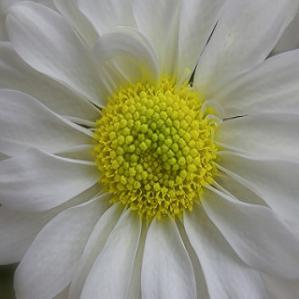

In [ ]:
model_inference('flower-sample', kubeflow_url, tf_request)

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all

## 3. KFServing with Kubeflow Pipeline

In [ ]:
import kfp.dsl as dsl
import kfp
from kfp import components
import json

# Create kfp client
# Note: Add the KubeFlow Pipeline endpoint below if the client is not running on the same cluster.
client = kfp.Client()
EXPERIMENT_NAME = 'KFServing Experiments'
experiment = client.create_experiment(name=EXPERIMENT_NAME)

In [ ]:
# Replace the `PIPELINE_RUNTIME` below to Argo if you are running with argo backend.
PIPELINE_RUNTIME = 'tekton'

### TensorFlow canary example

In this example, we will be serving two different TensorFlow models that trained on the same [tf_flower](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. Then, we deploy both models using canary deployment where user can configure the amount of request traffics on each model. 

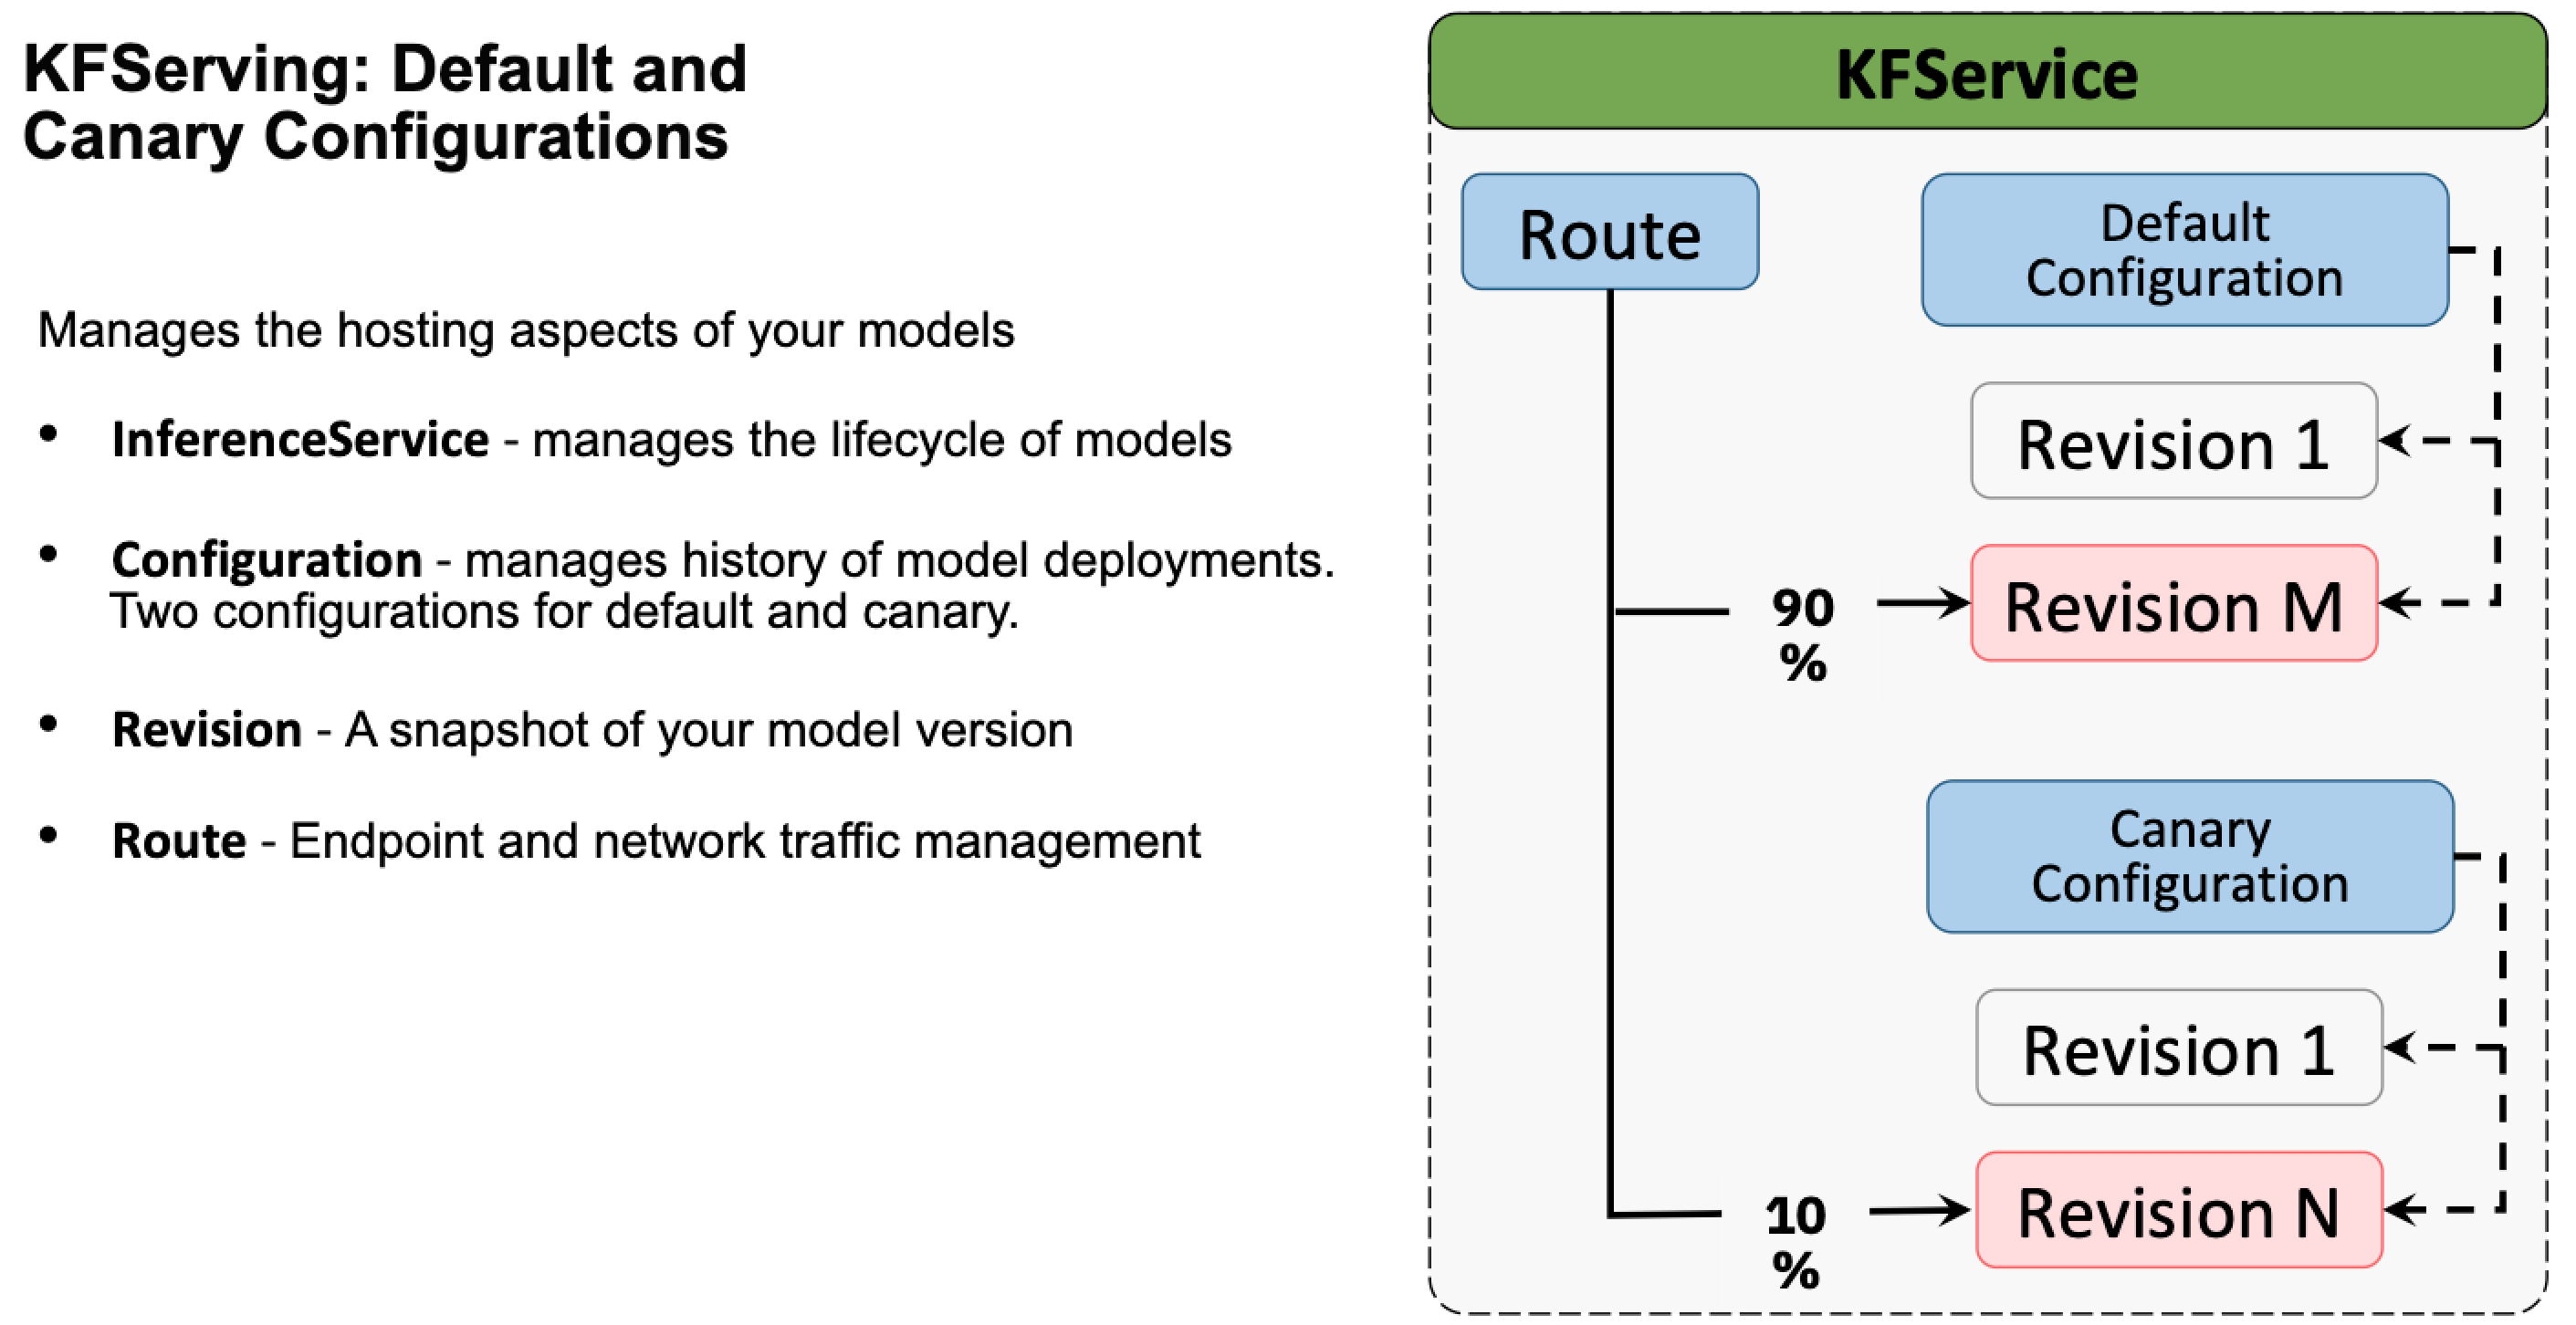

Note: Change the action from `create` to `update` if you are updating an existing model.

In [ ]:
kfserving_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/kfserving/component.yaml')

@dsl.pipeline(
  name='kfserving pipeline',
  description='A pipeline for kfserving.'
)
def kfservingPipeline(
    action = 'apply',
    model_name=model_name,
    default_model_uri='gs://kfserving-samples/models/tensorflow/flowers',
    canary_model_uri='gs://kfserving-samples/models/tensorflow/flowers-2',
    canary_model_traffic_percentage='10',
    namespace='anonymous',
    framework='tensorflow',
    default_custom_model_spec='{}',
    canary_custom_model_spec='{}',
    autoscaling_target='0',
    kfserving_endpoint=''
):

    # define workflow
    kfserving = kfserving_op(action = action,
                             model_name=model_name,
                             default_model_uri=default_model_uri,
                             canary_model_uri=canary_model_uri,
                             canary_model_traffic_percentage=canary_model_traffic_percentage,
                             namespace=namespace,
                             framework=framework,
                             default_custom_model_spec=default_custom_model_spec,
                             canary_custom_model_spec=canary_custom_model_spec,
                             autoscaling_target=autoscaling_target,
                             kfserving_endpoint=kfserving_endpoint).set_image_pull_policy('Always')

# Compile pipeline

if PIPELINE_RUNTIME == "tekton":
  from kfp_tekton.compiler import TektonCompiler
  TektonCompiler().compile(kfservingPipeline, 'tf-flower.tar.gz')
else:
  import kfp.compiler as compiler
  compiler.Compiler().compile(kfservingPipeline, 'tf-flower.tar.gz')

# Execute pipeline
run = client.run_pipeline(experiment.id, 'tf-flower', 'tf-flower.tar.gz')

### Test model inferencing once it's ready

In [ ]:
model_inference(model_name, kubeflow_url, tf_request)

### Infinite loop for generating inference traffics 

Here we will be generating traffics to our model, then using kiali, a istio monitoring tool, to visualize how the models are interacting with the incoming requests.

In [ ]:
while True:
    model_inference(model_name, kubeflow_url, tf_request)

## Promote the canary model to default model

Once we are satisfy with the canary model, we can promote the canary version to be the default and route 100% of the traffics to it.

In [ ]:
KFServing.promote('tf-flower')

In [ ]:
KFServing.get('tf-flower', watch=True, timeout_seconds=120)

# Clean up

In [ ]:
## clean up the previous examples
!kubectl delete inferenceservice --all
!kubectl delete job --all